In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from pygdsm import GlobalSkyModel
import uvtools
import healpy as hp
from scipy.interpolate import RectBivariateSpline
import aipy

In [3]:
CST_PATH = '/users/aewallwi/lustre/Vivaldi_Stripped_Down//Farfield/'
beamfiles = sorted(glob.glob(CST_PATH + '*.txt'))
beamfiles = beamfiles[-50:] + beamfiles[:-50]
beamfiles = beamfiles[:-1]

In [4]:
CST_PATH_DISH = '/users/aewallwi/lustre/Vivaldi feed + dish - detailed mecha design/Vivaldi 1.8m - detailed mecha design - E-field - 100 ohm load - Pol X/'
beamfiles_dish = sorted(glob.glob(CST_PATH_DISH + '*.txt'))
beamfiles_dish = beamfiles_dish[-50:] + beamfiles_dish[:-50]
beamfiles_dish = beamfiles_dish[:-1]

In [5]:
THETA_AXIS = 0
PHI_AXIS = 1
VOLT_AXIS = 2
freqs = np.array([float(f.split()[1][3:-1]) for f in beamfiles]) / 1000 # GHz
thetas, phis = np.loadtxt(beamfiles[0], skiprows=2, usecols=(THETA_AXIS,PHI_AXIS)).T
thetas = np.deg2rad(np.unique(thetas))
phis = np.deg2rad(np.unique(phis))
data = np.array([np.loadtxt(f, skiprows=2, usecols=VOLT_AXIS) for f in beamfiles])
data.shape = (-1, phis.size, thetas.size)

In [6]:
NPIX = 129
L = np.linspace(-1, 1, NPIX,endpoint=True)
M = np.linspace(-1, 1, NPIX,endpoint=True)
L.shape = (-1, 1)
M.shape = ( 1,-1)
L = L * np.ones_like(M)
M = M * np.ones_like(L)
LM = L**2 + M**2
N = np.where(LM < 1, np.sqrt(1 - LM), 0)
th = np.arccos(L).flatten()
ph = np.arctan2(M, N).flatten() - np.pi
ph = np.where(ph < 0, 2*np.pi+ph, ph)

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [7]:
mask = np.where(LM < 1, 1, 0)
beams = np.array([RectBivariateSpline(phis, thetas, d)(ph, th, grid=False)**2 for d in data])
beams.shape = (-1, NPIX, NPIX)
beams *= mask
print(beams.shape)

(200, 129, 129)


<IPython.core.display.Javascript object>


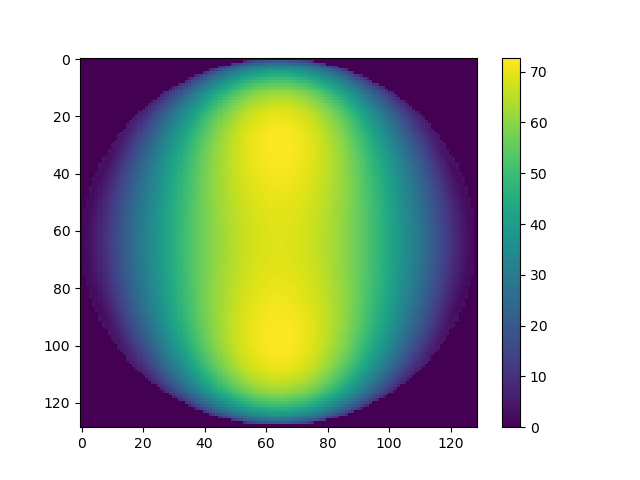

In [8]:
plt.figure()
uvtools.plot.waterfall(beams[100], mode='real')
plt.colorbar()

In [9]:
beamfiles_dish[0]

'/users/aewallwi/lustre/Vivaldi feed + dish - detailed mecha design/Vivaldi 1.8m - detailed mecha design - E-field - 100 ohm load - Pol X/farfield (f=50) [1].txt'

In [10]:
THETA_AXIS = 0
PHI_AXIS = 1
VOLT_AXIS = 2
freqs = np.array([float(f.split('=')[1].split(')')[0]) for f in beamfiles_dish]) / 1000 # GHz
thetas_dish, phis_dish = np.loadtxt(beamfiles_dish[0], skiprows=2, usecols=(THETA_AXIS,PHI_AXIS)).T
thetas_dish = np.deg2rad(np.unique(thetas_dish))
phis_dish = np.deg2rad(np.unique(phis_dish))
data_dish = np.array([np.loadtxt(f, skiprows=2, usecols=VOLT_AXIS) for f in beamfiles_dish])
data_dish.shape = (-1, phis_dish.size, thetas.size)

<IPython.core.display.Javascript object>


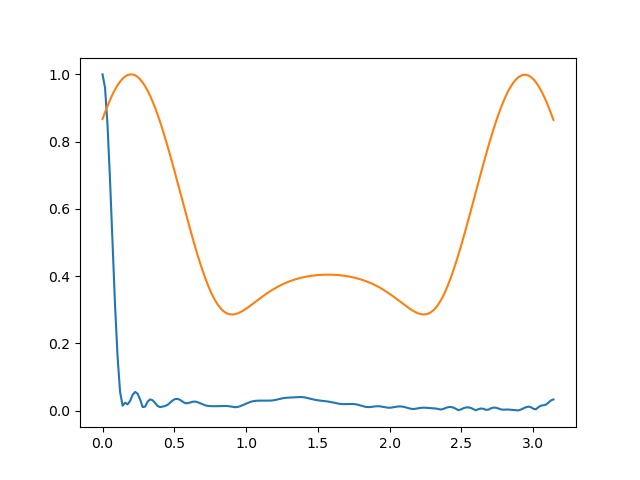

In [11]:
plt.figure()
plt.plot(thetas_dish, data_dish[-1,0,:]/data_dish[-1,0,:].max())
plt.plot(thetas, data[-1,0,:]/data[-1,0,:].max())

In [12]:
NPIX = 129
LD = np.linspace(-1, 1, NPIX,endpoint=True)
MD = np.linspace(-1, 1, NPIX,endpoint=True)
LD.shape = (-1, 1)
MD.shape = ( 1,-1)
LD = LD * np.ones_like(MD)
MD = MD * np.ones_like(LD)
LMD = LD**2 + MD**2
ND = np.where(LMD < 1, np.sqrt(1 - LMD), 0)
th_d = np.arcsin(LMD**.5).flatten()
ph_d = np.arctan2(MD, ND).flatten() - np.pi
ph_d = np.where(ph_d < 0, 2*np.pi+ph_d, ph_d)

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in arcsin
  # Remove the CWD from sys.path while we load stuff.


In [13]:
maskd = np.where(LMD < 1, 1, 0)
beams_dish = np.array([RectBivariateSpline(phis_dish, thetas_dish, d)(ph_d, th_d, grid=False)**2 for d in data_dish])
beams_dish.shape = (-1, NPIX, NPIX)
beams_dish *= maskd

In [14]:
beams_dish[~np.isfinite(beams_dish)] = 0.

<IPython.core.display.Javascript object>


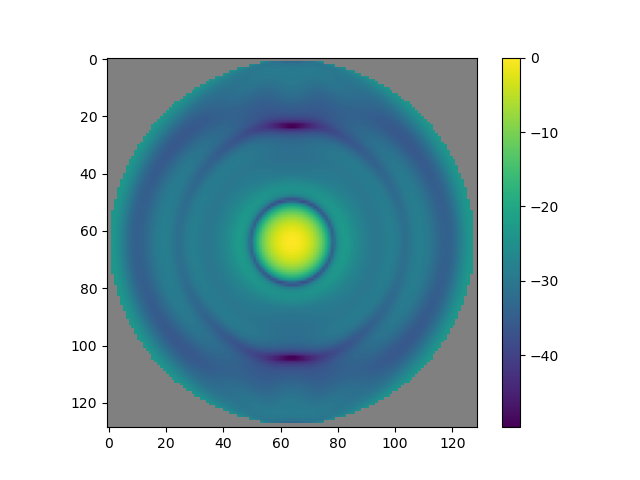

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [15]:
plt.figure()
plt.imshow(10*np.log10(beams_dish[100] / beams_dish[100].max()))
plt.colorbar()
plt.savefig('plots/dish_beam.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


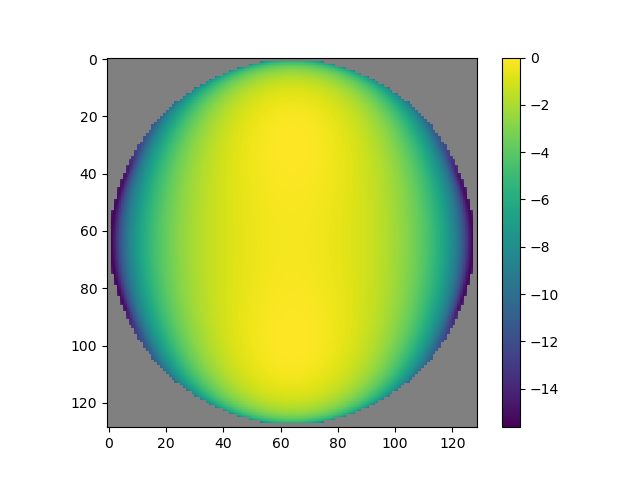

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [16]:
plt.figure()
plt.imshow(10*np.log10(beams[100] / beams[100].max()))
plt.colorbar()
plt.savefig('plots/feed_beam.png',bbox_inches='tight')

# Load up GSM

In [17]:
NSIDE = 64
hpb = aipy.healpix.HealpixBase(nside=NSIDE)
I_sky = np.empty((freqs.size, hpb.npix()))
gsm = GlobalSkyModel(freq_unit='GHz')
ga2eq = aipy.coord.convert_m('ga', 'eq')
for ch,f in enumerate(freqs):
    if NSIDE == 512:
        I_sky[ch] = gsm.generate(f)
    else:
        I_sky[ch] = hp.ud_grade(gsm.generate(f), nside_out=NSIDE)

In [18]:
NTIMES = 256
JD = 2459117
jds = np.linspace(JD, JD+1, NTIMES)

crd_eq = np.array(hpb.px2crd(np.arange(hpb.npix())))
antpos = np.array([[0.,0,0]]) # meters
loc = ('40:00', '0:00')
aa = aipy.amp.AntennaArray(loc, antpos)

eq2tops = []
for jd in jds:
    aa.set_jultime(jd)
    eq2tops.append(np.dot(aa.eq2top_m, ga2eq))
eq2tops = np.array(eq2tops)

<IPython.core.display.Javascript object>


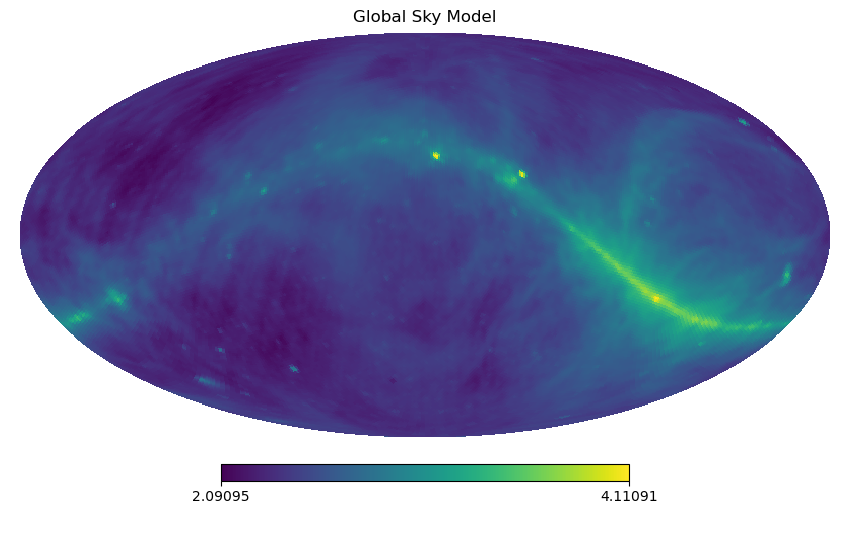

In [19]:
rot=hp.Rotator(coord=['G','C'])
hp.mollview(np.log10(rot.rotate_map_pixel(I_sky[100])), rot=[0,30,0], title='Global Sky Model')
plt.savefig('plots/gsm.png', bbox_inches='tight')


<IPython.core.display.Javascript object>


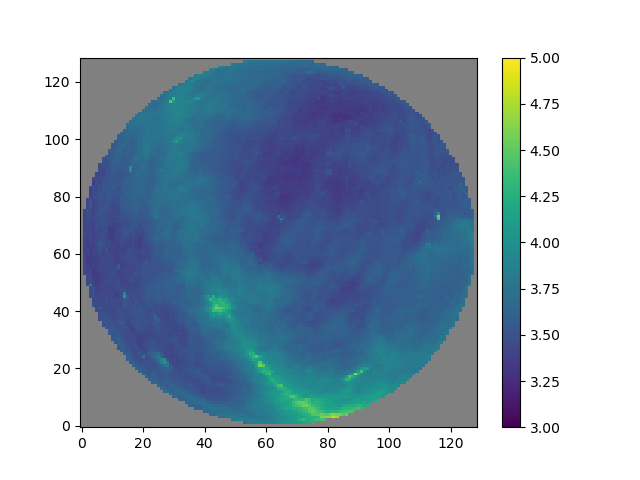

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/uvtools/plot.py:42: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


In [20]:
hpm = aipy.healpix.HealpixMap(nside=NSIDE)
hpm.map = I_sky[0]
top = (M.flatten(), L.flatten(), N.flatten())
gx,gy,gz = np.dot(np.linalg.inv(np.dot(eq2tops[150], ga2eq)), top)
img = hpm[gx,gy,gz]
img.shape = (NPIX,NPIX)
plt.figure()
uvtools.plot.waterfall(mask * img, mode='log', mx=5, drng=2, origin='lower')
_ = plt.colorbar()

In [21]:
if not os.path.exists('auto.npz'):
    #from hera_gpu.vis import vis_gpu as vis
    from hera_sim.visibilities.vis_cpu import vis_cpu as vis

    data = np.empty((NTIMES,freqs.size), dtype=np.complex64)
    for ch in range(freqs.size):
        print(ch)
        data[:,ch] = vis(antpos, freqs[ch], eq2tops, crd_eq, I_sky[ch], beams[ch:ch+1])[:,0,0]
    np.savez('auto.npz', data=data, freqs=freqs, jds=jds)
else:
    print('Reading from file')
    npz = np.load('auto.npz')
    data = npz['data']
    jds = npz['jds']
    freqs = npz['freqs']

Reading from file


In [ ]:
import os
os.remove('auto_dish.npz')

In [22]:
if not os.path.exists('auto_dish.npz'):
    #from hera_gpu.vis import vis_gpu as vis
    from hera_sim.visibilities.vis_cpu import vis_cpu as vis

    data_dish = np.empty((NTIMES,freqs.size), dtype=np.complex64)
    for ch in range(freqs.size):
        print(ch)
        data_dish[:,ch] = vis(antpos, freqs[ch], eq2tops, crd_eq, I_sky[ch], beams_dish[ch:ch+1])[:,0,0]
    np.savez('auto_dish.npz', data=data, freqs=freqs, jds=jds)
else:
    print('Reading from file')
    npz = np.load('auto_dish.npz')
    data_dish = npz['data']
    jds = npz['jds']
    freqs = npz['freqs']

Reading from file


In [23]:
def dayenu(dat, width=1.):
    _, rdat, _ = uvtools.dspec.fourier_filter(
                                x=freqs * 1e9,
                                data=dat,
                                wgts=np.ones_like(dat),
                                mode='dpss_leastsq',
                                filter_centers=[0.],
                                filter_half_widths=[width * 1e-9],
                                eigenval_cutoff=[1e-12],
                                suppression_factors=[1e-9]
    )
    return rdat

rdata = dayenu(data / data[55]) * data[55]

In [24]:
ARES_PATH = '../../'
models = np.load(ARES_PATH + 'models_21cm.npz')['models'] / 1e3 # K
mfreqs = np.load(ARES_PATH + 'models_21cm.npz')['freqs']

In [25]:
fake_eor = models[78]


In [26]:
gain = beams[:,NPIX//2+1,NPIX//2+1]
avg = np.mean(data[-50:], axis=0) / gain
cal = 180 / avg[np.argmin(np.abs(freqs-0.180))]


gain_dish = beams_dish[:,NPIX//2+1, NPIX//2+1]
avg_dish = np.mean(data_dish[-50:], axis=0) / gain_dish
cal_dish = 180 / avg_dish[np.argmin(np.abs(freqs-0.180))]


<IPython.core.display.Javascript object>


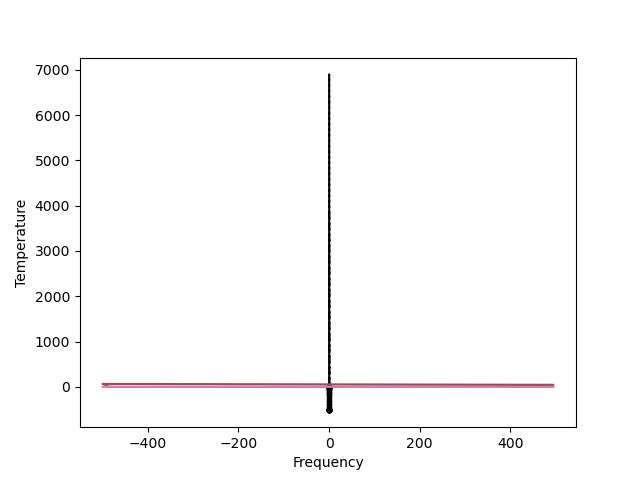

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [27]:
def gen_eor(A, nu0, w, tau):
    B = 4 * (freqs - nu0)**2 / w**2 * np.log(-1/tau * np.log((1+np.exp(-tau))/2))
    return -A * (1 - np.exp(-tau * np.exp(B))) / (1 - np.exp(-tau))

prms = {
    'A': 0.52,
    'nu0': 78.3e-3,
    'w': 20.7e-3,
    'tau': 6.5,
}
fake_eor = gen_eor(**prms)
#fake_eor = models[185]

idata_dish = cal_dish * data_dish / gain_dish + fake_eor
idata = cal * data / gain + fake_eor

plt.figure()

for mdl in models:
    plt.plot(freqs, 1e3*mdl)
plt.plot(freqs, 1e3*fake_eor, 'k.-')
plt.plot(freqs, idata[0], 'k:')
plt.plot(freqs, idata_dish[0], 'k--')

plt.xlabel('Frequency')
_ = plt.ylabel('Temperature')

Make a delay plot

In [32]:
import scipy.signal as signal

<IPython.core.display.Javascript object>


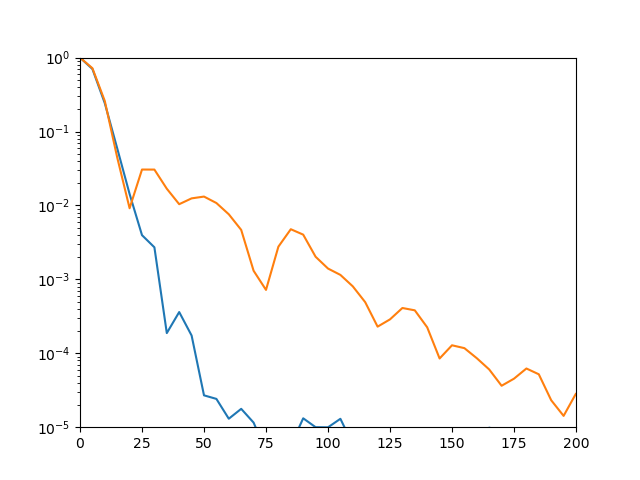

(1e-05, 1.0)

In [42]:
bh = signal.blackmanharris(200)
bh /= bh.mean()
beam_fft = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh * beams[:, 65, 65].squeeze())))
beam_dish_fft = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh * beams_dish[:, 65, 65].squeeze())))

dlys = np.fft.fftshift(np.fft.fftfreq(200, np.mean(np.diff(freqs))))
plt.figure()
plt.plot(dlys, np.abs(beam_fft / beam_fft.max()))
plt.plot(dlys, np.abs(beam_dish_fft / beam_dish_fft.max()))
plt.xlim(0,200)
plt.yscale('log')
plt.ylim(1e-5, 1e0)

In [45]:
#def dayenu(data):
#    return data

#idata = cal * data / gain + fake_eor

tint = 3600. * 50. 
DF = np.mean(np.diff(freqs))
noise = idata * np.random.randn(*idata.shape) / np.sqrt(DF * 1e9 * tint)
noise_d = idata_dish * np.random.randn(*idata_dish.shape) / np.sqrt(DF * 1e9 * tint)

# Build a filter to exclude EoR from calibration signal
d = idata - np.mean(idata[-50:], axis=0)
dd = idata_dish - np.mean(idata_dish[-50:], axis=0)

C = np.dot(d.T, d)
Cd = np.dot(dd.T, dd)
U,S,V = np.linalg.svd(C)
Ud,Sd,Vd = np.linalg.svd(Cd)

#plt.figure(); plt.plot(S)
iS = np.identity(S.size)

#iS[10:,10:] = 0
iS[5:,5:] = 0
Cinv = np.dot(V.T, np.dot(iS, U.T))

Cinvd = np.dot(Vd.T, np.dot(iS, Ud.T))

#pcal = idata[55] - 0.5 * fake_eor # XXX
pcal = np.dot(Cinv, idata[55]) # filter to exclude most of eor signal
pcald = np.dot(Cinvd, idata_dish[55]) # filter to exclude most of eor signal

reor = dayenu(fake_eor / pcal) * pcal
rmodels = dayenu(models / pcal) * pcal

reord = dayenu(fake_eor / pcald) * pcald
rmodelsd = dayenu(models / pcald) * pcald


idata_flattened = dayenu(idata / pcal) * pcal
idata_flattened_dish = dayenu(idata_dish / pcald) * pcald

noise_flattened = dayenu(noise / pcal) * pcal
noise_flattened_dish = dayenu(noise / pcald) * pcald


/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


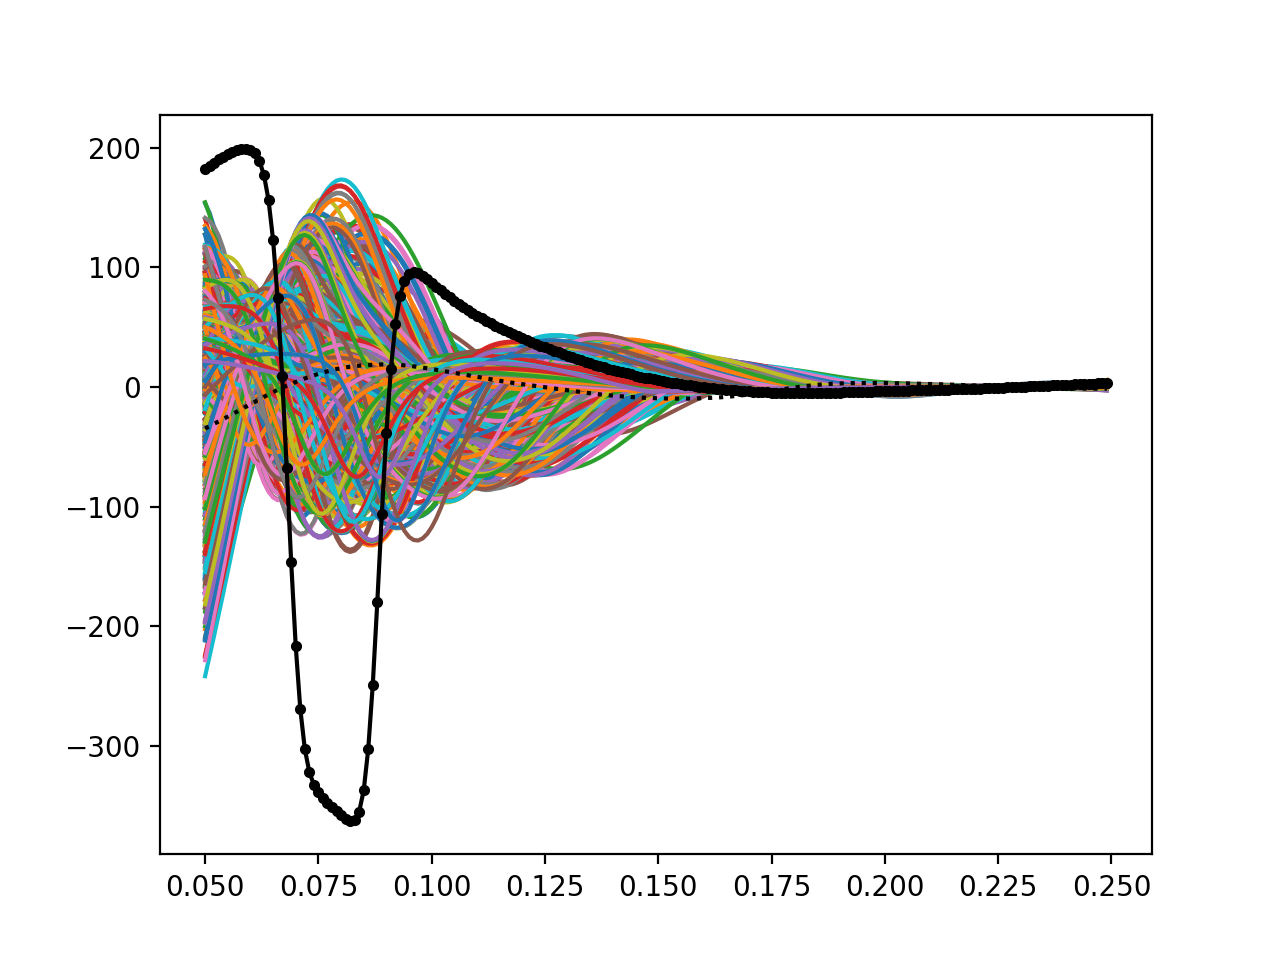

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/h

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/h

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/h

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/h

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/h

In [616]:
plt.figure()
for mdl in rmodels:
    plt.plot(freqs, 1e3*mdl)
plt.plot(freqs, 1e3*reor, 'k.-')
plt.plot(freqs, idata_flattened[0], 'k:')

In [620]:
d = idata_flattened - np.mean(idata_flattened[-50:], axis=0)
C = np.dot(d.T, d)
U,S,V = np.linalg.svd(C)



dd = idata_flattened_dish - np.mean(idata_flattened_dish[-50:], axis=0)
Cd = np.dot(dd.T, dd)
Ud,Sd,Vd = np.linalg.svd(Cd)

In [621]:
m = rmodels - np.mean(rmodels, axis=0)
Cm = np.dot(m.T, m)
Um, Sm, Vm = np.linalg.svd(Cm)

In [622]:
m = rmodelsd - np.mean(rmodelsd, axis=0)
Cmd = np.dot(m.T, m)
Umd, Smd, Vmd = np.linalg.svd(Cmd)

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


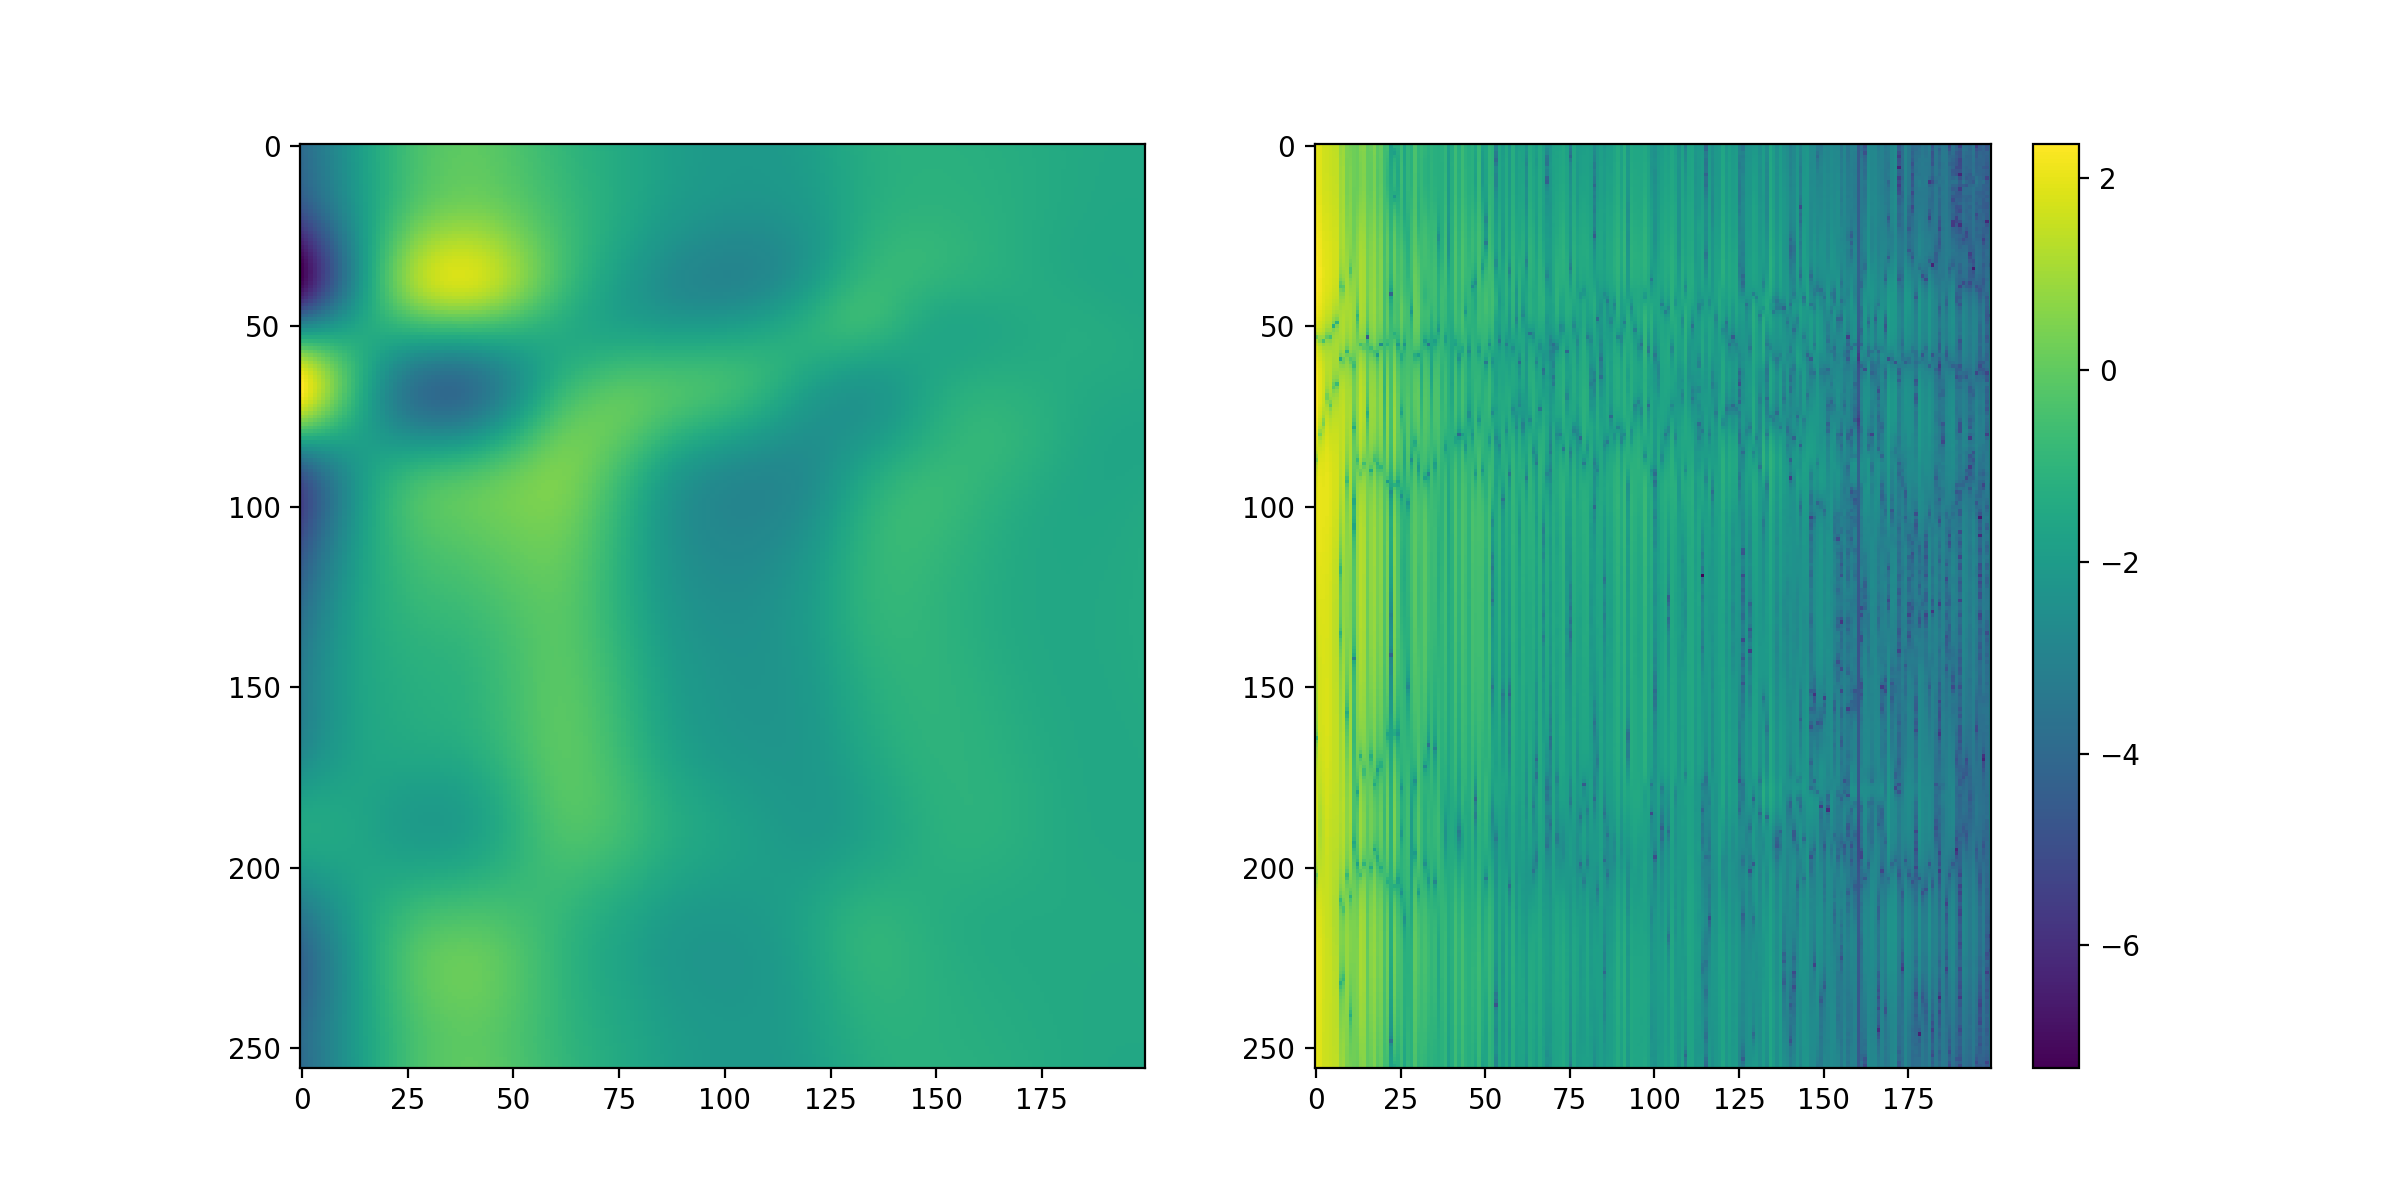

In [623]:
plt.figure(figsize=(12,6))
plt.subplot(121)
uvtools.plot.waterfall(idata_flattened, mode='real')
plt.subplot(122)
uvtools.plot.waterfall(np.dot(Vm, idata_flattened.T).T, mode='log')
_ = plt.colorbar()

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


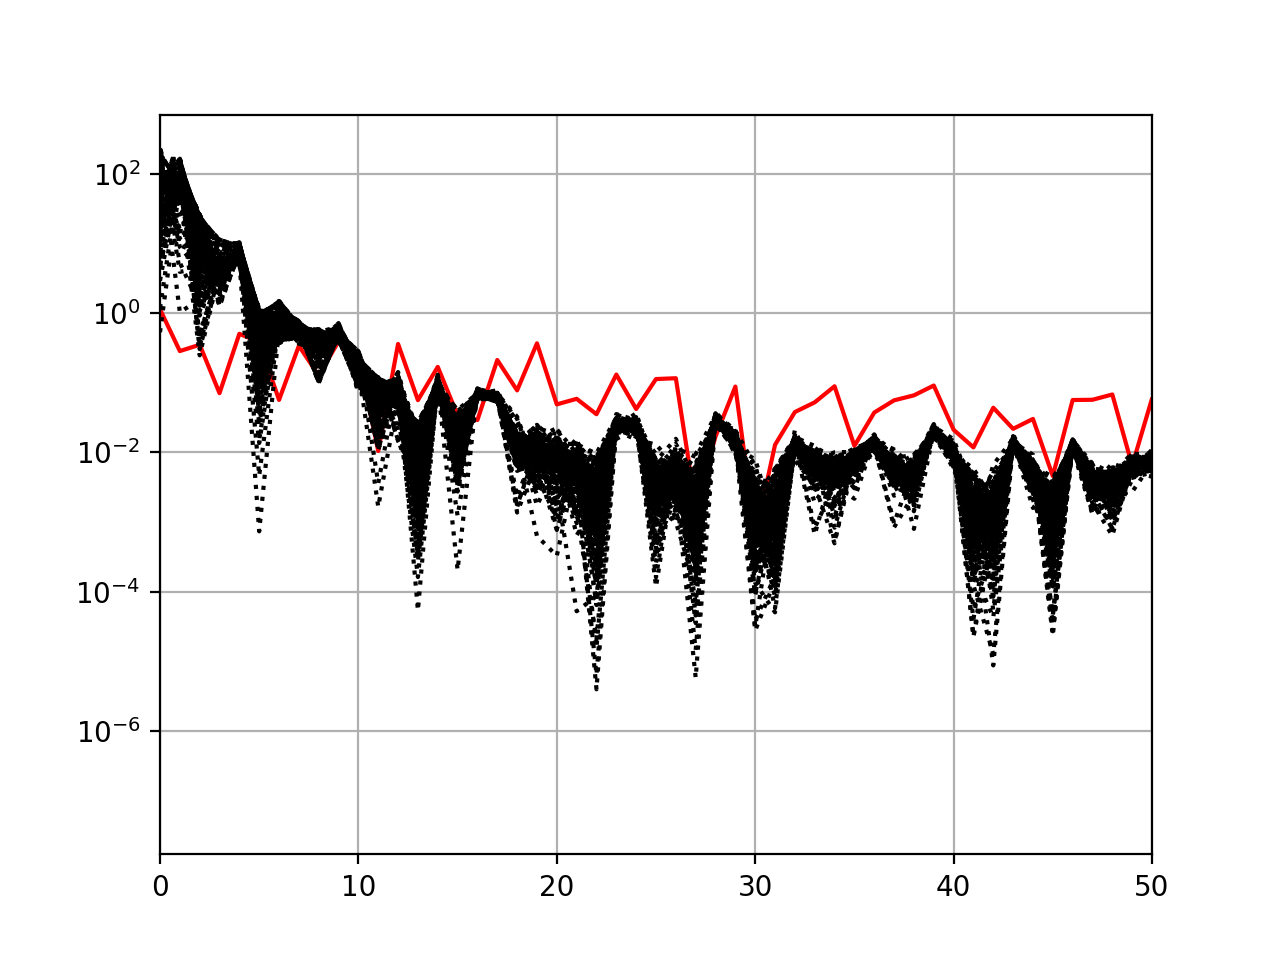

(1135, 200)


(0.0, 50.0)

In [624]:
plt.figure()
print(rmodels.shape)
#plt.semilogy(np.abs(np.dot(V, rmodels[78:79].T))**2)
plt.semilogy(np.abs(np.dot(V, reor)),'r')
#plt.semilogy(S, 'k.-')
plt.semilogy(np.abs(np.dot(V, (idata_flattened[55:] - reor).T)), 'k:')
#plt.semilogy(np.abs(np.dot(V, (idata[-50:]).T))**2, 'r:')
plt.grid()
plt.xlim(0,50)

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


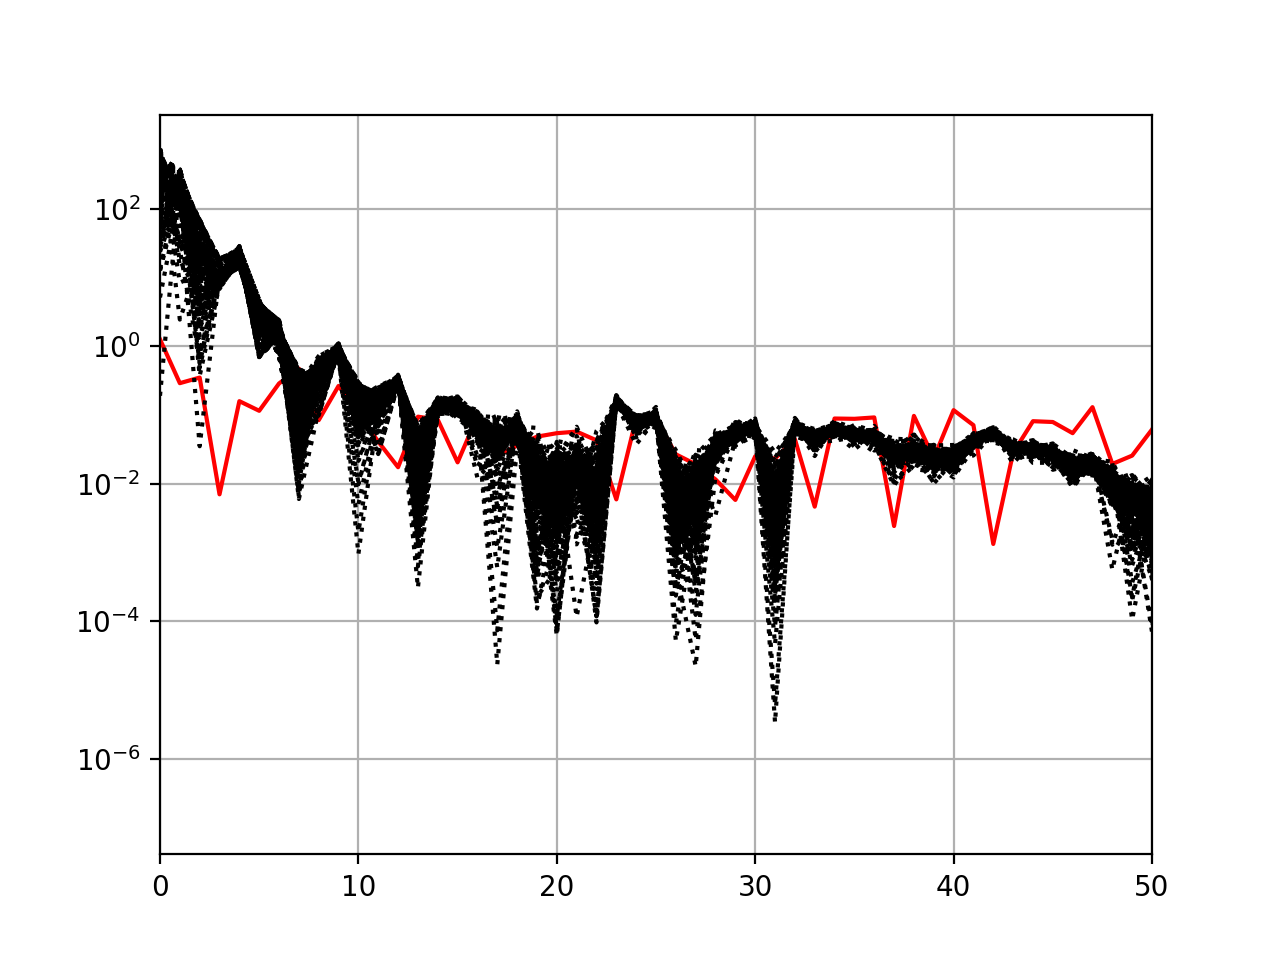

(1135, 200)


(0.0, 50.0)

In [625]:
plt.figure()
print(rmodels.shape)
#plt.semilogy(np.abs(np.dot(V, rmodels[78:79].T))**2)
plt.semilogy(np.abs(np.dot(Vd, reord)),'r')
#plt.semilogy(S, 'k.-')
plt.semilogy(np.abs(np.dot(Vd, (idata_flattened_dish[55:] - reord).T)), 'k:')
#plt.semilogy(np.abs(np.dot(V, (idata[-50:]).T))**2, 'r:')
plt.grid()
plt.xlim(0,50)

In [626]:
dot_matrix = np.zeros((len(freqs), len(freqs)))
dot_matrix_d = np.zeros_like(dot_matrix)
for i in range(dot_matrix.shape[0]):
    for j in range(dot_matrix.shape[1]):
        dot_matrix[i, j] = Vm[i] @ V[j] * np.sqrt( Sm[i])
        dot_matrix_d[i, j] = Vm[i] @ Vd[j] * np.sqrt(Smd[i])

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [627]:
dot_matrix 

array([[ 7.14410162e+00, -2.50618186e+00, -1.44352639e+00, ...,
        -7.85114120e-06, -9.32547795e-05,  2.98478747e-06],
       [-2.14890971e+00, -1.09119269e+00,  3.80201964e-01, ...,
        -3.19762168e-07, -2.05262693e-06,  6.26541809e-08],
       [ 4.25099890e-01,  8.98511695e-01,  8.70187060e-01, ...,
        -5.06557844e-06, -5.81870598e-05,  1.83489965e-06],
       ...,
       [-1.60430850e-13,  2.22122644e-13, -1.65708441e-12, ...,
         1.28113826e-08,  7.54930050e-10, -2.82050605e-09],
       [-1.83013913e-14,  1.96638291e-13,  6.78139165e-14, ...,
        -2.90714867e-09, -3.39825296e-11, -5.78224867e-09],
       [ 3.13953109e-13, -5.48527380e-13,  2.61586731e-13, ...,
        -1.79487341e-09,  7.53086808e-11,  6.98879216e-09]])

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


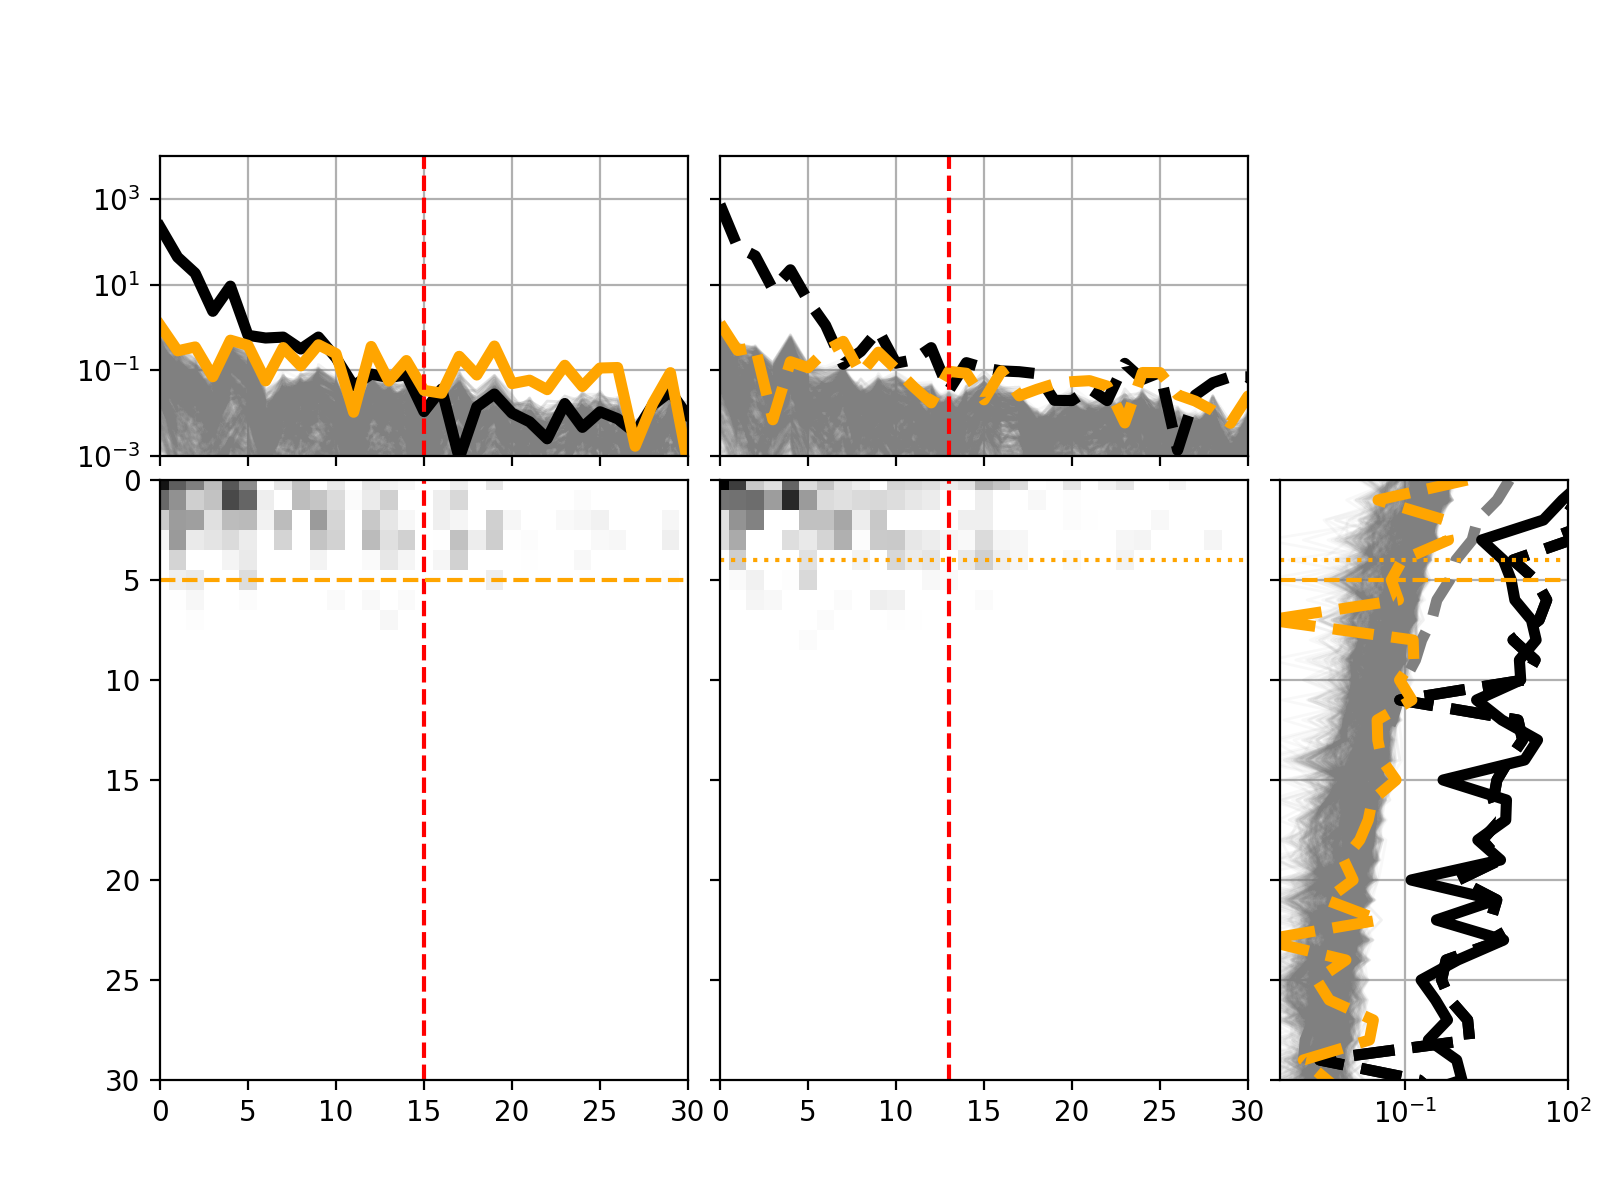

In [628]:
import matplotlib.colors as colors
fig = plt.figure()
h_gap = 0.04
axarr=[fig.add_axes([0.1, 0.1, .35-h_gap/2, .5]), fig.add_axes([0.45, 0.1, .35-h_gap/2, .5]),
       fig.add_axes([0.8, 0.1, 0.2-h_gap/2, .5])]
axarr = [[fig.add_axes([0.1, 0.6+h_gap/2, .35-h_gap/2, .25]),
          fig.add_axes([0.45, 0.6+h_gap/2, .35-h_gap/2, .25])],
          axarr]




plt.sca(axarr[0][0])
plt.semilogy(np.abs(np.dot(V, rmodels.T)), lw=1, alpha=.05, color='grey')
x = np.abs(np.dot(V, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reord).T))
threshold_fg = np.where(x < x.max()*1e-4)[0].min()
plt.semilogy(x, 'k-', lw=4)
plt.semilogy(np.abs(np.dot(V, reor)),color='orange', lw=4)
#index_tm4 = np.argmin(np.dot(V, ))
plt.axvline(threshold_fg, color='r', ls='--')
plt.grid()
plt.gca().set_xticklabels([])


plt.ylim(1e-3, 1e4)
plt.xlim(0,30)

plt.sca(axarr[0][1])
#plt.semilogy(np.abs(np.dot(Vd, )))
plt.semilogy(np.abs(np.dot(Vd, rmodelsd.T)), lw=1, alpha=.05, color='grey')
xd = np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T))
threshold_fg_d = np.where(xd < xd.max()*1e-4)[0].min()

plt.semilogy(np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
             'k--', lw=4)
plt.semilogy(np.abs(np.dot(Vd, reord)),color='orange', lw=4, ls='--')

plt.grid()
plt.axvline(threshold_fg_d, color='r', ls='--')

plt.ylim(1e-3, 1e4)
plt.xlim(0,30)
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])


threshold_21cm = np.where(np.abs(np.sqrt(np.abs(Sm)) < .1 * np.sqrt(np.abs(Sm)).max()))[0].min()
threshold_21cmd = np.where(np.abs(np.sqrt(np.abs(Smd)) < .1 * np.sqrt(np.abs(Smd)).max()))[0].min()

plt.sca(axarr[1][2])
plt.semilogx(np.sqrt(np.abs(Vm @ rmodels.T)), np.arange(len(freqs)),lw=1, color='grey', ls = '-', alpha=0.05)

plt.semilogx(np.sqrt(np.abs(Sm)), np.arange(len(freqs)),lw=4, color='grey', ls = '--')
plt.semilogx(np.abs(np.dot(Vm, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T)),
                                np.arange(len(freqs)), lw=4, ls='-', color='k')
plt.semilogx(np.abs(np.dot(Vm, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
                                np.arange(len(freqs)), lw=4, ls='--', color='k')
plt.semilogx(np.abs(np.dot(Vm, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
                                np.arange(len(freqs)), lw=4, ls='--', color='k')
plt.semilogx(np.abs(np.dot(Vm, reor)), np.arange(len(freqs)), ls='--', color='orange', lw=4)
plt.axhline(threshold_21cm, color='orange', ls='--')
plt.axhline(threshold_21cmd, color='orange', ls=':')

plt.ylim(30,0)
plt.grid()
plt.xlim(5e-4, 1e2)
plt.gca().set_yticklabels([])


plt.sca(axarr[1][0])
plt.imshow(np.abs(dot_matrix), cmap='Greys', interpolation='nearest', aspect='auto', norm=colors.LogNorm(1e-1,1e1))
#plt.colorbar()
plt.xlim(0, 30)
plt.ylim(30, 0)
# find 99.9 percent eigenval for foregrounds
plt.axvline(threshold_fg, color='r', ls='--')
plt.axhline(threshold_21cm, color='orange', ls='--')



plt.sca(axarr[1][1])
plt.imshow(np.abs(dot_matrix_d),  cmap='Greys', interpolation='nearest', aspect='auto', norm=colors.LogNorm(1e-1,1e1))
#plt.colorbar()
plt.xlim(0, 30)
plt.ylim(30, 0)
plt.axvline(threshold_fg_d, color='r', ls='--')
plt.gcf().set_size_inches(8, 6)
plt.gca().set_yticklabels([])
plt.axhline(threshold_21cmd, color='orange', ls=':')

plt.savefig('pc_dot_plot.png', bbox_inches='tight')

In [629]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


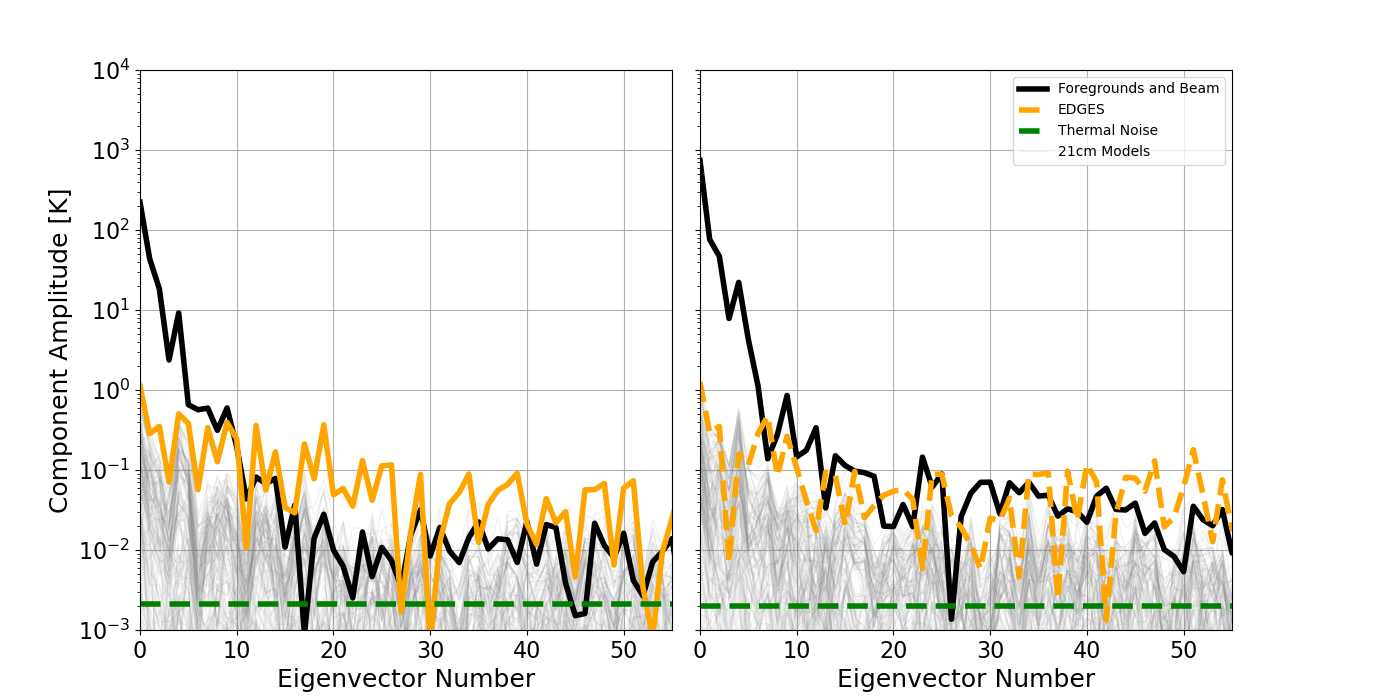

In [646]:
import matplotlib.colors as colors
fig = plt.figure()
h_gap = 0.04
axarr=[fig.add_axes([0.1, 0.1, .4-h_gap/2, .8]), fig.add_axes([.4+.1, 0.1, .4-h_gap/2, .8])]


plt.sca(axarr[0])
plt.semilogy(np.abs(np.dot(V, rmodels.T))[:, ::10], lw=1, alpha=.1, color='grey')
x = np.abs(np.dot(V, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reord).T))
threshold_fg = np.where(x < x.max()*1e-4)[0].min()
plt.semilogy(x, 'k-', lw=4)
plt.semilogy(np.abs(np.dot(V, reor)),color='orange', lw=4)
plt.axhline(np.mean(np.abs(np.dot(Vd, (noise_flattened[np.argmin(np.mean(idata_flattened, axis=1))]).T))),
             ls='--', color='green', lw=4)
#index_tm4 = np.argmin(np.dot(V, ))
#plt.axvline(threshold_fg, color='r', ls='--')
plt.grid()
#plt.gca().set_xticklabels([])
plt.gca().tick_params(labelsize=16)
plt.ylim(1e-3, 1e4)
plt.xlim(0,55)
plt.xlabel('Eigenvector Number', fontsize=18)
plt.ylabel('Component Amplitude [K]', fontsize=18)




plt.sca(axarr[1])
#plt.semilogy(np.abs(np.dot(Vd, )))
l3=plt.semilogy(np.abs(np.dot(Vd, rmodelsd.T))[:, ::10], lw=1, alpha=.1, color='grey')[0]
xd = np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T))
threshold_fg_d = np.where(xd < xd.max()*1e-4)[0].min()

l0=plt.semilogy(np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
             'k-', lw=4)[0]
l1=plt.semilogy(np.abs(np.dot(Vd, reord)),color='orange', lw=4, ls='--')[0]
l2=plt.axhline(np.mean(np.abs(np.dot(Vd, (noise_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))]).T))),
             color='green', ls='--', lw=4)

plt.legend((l0, l1, l2, l3), ('Foregrounds and Beam', 'EDGES', 'Thermal Noise', '21cm Models'))
plt.grid()
plt.gca().tick_params(labelsize=16)
#plt.axvline(threshold_fg_d, color='r', ls='--')

plt.ylim(1e-3, 1e4)
plt.xlim(0,55)
plt.gca().set_yticklabels([])
#plt.gca().set_xticklabels([])
plt.xlabel('Eigenvector Number', fontsize=18)

threshold_21cm = np.where(np.abs(np.sqrt(np.abs(Sm)) < .1 * np.sqrt(np.abs(Sm)).max()))[0].min()
threshold_21cmd = np.where(np.abs(np.sqrt(np.abs(Smd)) < .1 * np.sqrt(np.abs(Smd)).max()))[0].min()



plt.gcf().set_size_inches(14, 7)




plt.savefig('pc_plot.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


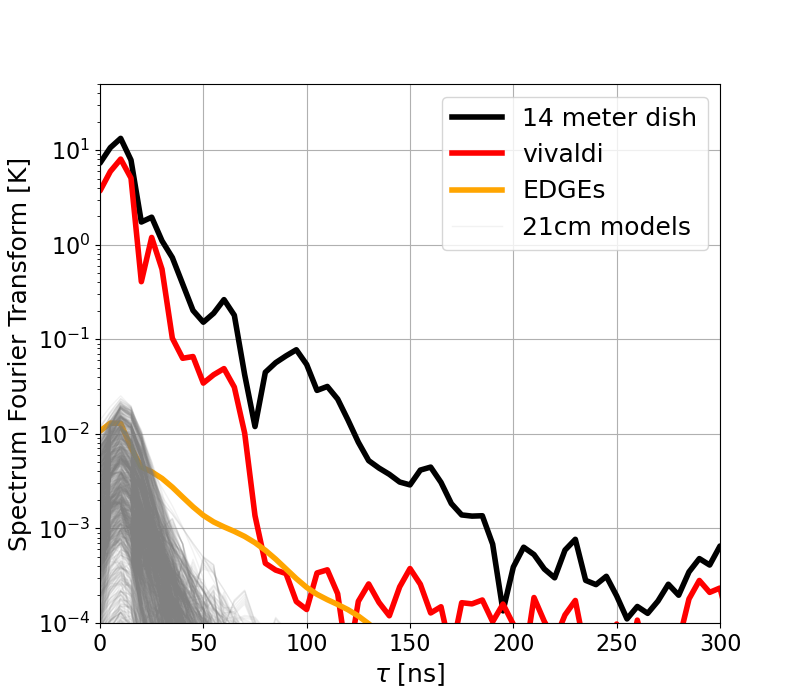

In [88]:
plt.figure()
x=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh * (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T)))
y=np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh * (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)))
#x[dlys>=125] = 0
l0=plt.plot(dlys, np.abs(y), color='k', label='14 meter Dish', lw=4)[0]
l1=plt.plot(dlys, np.abs(x), color='r', label='Vivaldi Antenna',lw=4)[0]
l2=plt.plot(dlys, np.abs(np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh * reor)))), label='EDGEs', color='orange',lw=4)[0]
l3=plt.plot(dlys, np.abs(np.fft.fftshift(np.fft.ifft(np.fft.fftshift(bh[None,:] * rmodels, axes=1), axis=1), axes=1)).T, color='grey', lw=1, alpha=0.1)[0]
plt.legend([l0, l1, l2, l3], ['14 meter dish', 'vivaldi', 'EDGEs', '21cm models'], loc='best', fontsize=18)
plt.yscale('log')
plt.xlim(0, 300)
plt.ylim(1e-4,5e1)
plt.grid()
plt.xlabel('$\\tau$ [ns]', fontsize=18)
plt.ylabel('Spectrum Fourier Transform [K]', fontsize=18)
plt.gca().tick_params(labelsize=16)
plt.gcf().set_size_inches(8,7)
plt.savefig('plots/delay_transform_plot.png', bbox_inches='tight')

In [685]:
np.sqrt(DF * 1e9 * tint)

424264.0687119285

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


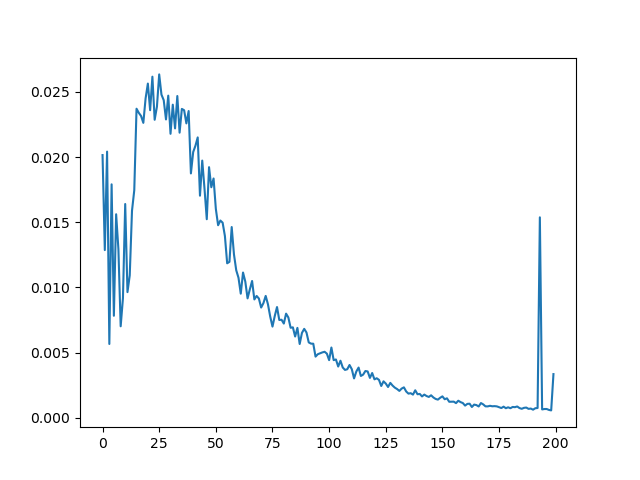

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [689]:
plt.figure()
plt.plot(noise_level)

In [715]:
import matplotlib.colors as colors
fig = plt.figure()
h_gap = 0.04
axarr=[fig.add_axes([0.1, 0.2, .8/3-h_gap/2, .8]), fig.add_axes([.8/3+.1, 0.2, .8/3-h_gap/2, .8]), fig.add_axes([2*.8/3+.1, 0.2, .8/3-h_gap/2, .8])]

plt.sca(axarr[0])
l0=plt.semilogy(freqs * 1e3, np.abs(idata[np.argmin(np.mean(idata_flattened, axis=1))] - reor), color='r', lw=4, ls=':')[0]
l1=plt.semilogy(freqs * 1e3, np.abs(idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reor), color='k', lw=4, ls=':')[0]

l2=plt.semilogy(freqs * 1e3, np.abs(idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor), color='r', lw=4)[0]
l3=plt.semilogy(freqs * 1e3, np.abs(idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reor), color='k', lw=4)[0]
l6=plt.semilogy(freqs * 1e3, np.abs(rmodels.T)[:, ::10], lw=1, alpha=.5, color='grey')[0]
l4=plt.semilogy(freqs * 1e3, np.abs(reor), color='orange', lw=4)[0]
l5=plt.semilogy(freqs * 1e3, np.abs(fake_eor), color='orange', ls=':', lw=4)[0]


l7=plt.semilogy(freqs * 1e3, np.abs(idata[np.argmin(np.mean(idata_flattened, axis=1))]) / np.sqrt(DF * 1e9 * tint), color='green', ls='--', lw=4)[0]
fig.legend((l2, l3, l5, l6, l7), ('Foregrounds, Vivalid', 'Foregrounds Dish', 'EDGEs', '21cm Models', 'Thermal Noise'), loc='lower center' ,ncol=5, fontsize=14)

plt.ylabel('|T| [K]', fontsize=18)
plt.grid()
plt.ylim(1e-3, 5e3)
plt.xlim(55, 245)
plt.gca().tick_params(labelsize=16)
plt.xlabel("$\\nu$ [MHz]", fontsize=18)


plt.sca(axarr[2])
plt.semilogy(np.abs(np.dot(V, rmodels.T))[:, ::10], lw=1, alpha=.5, color='grey')
x = np.abs(np.dot(V, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reord).T))
threshold_fg = np.where(x < x.max()*1e-4)[0].min()
noise_level = np.sqrt(np.diag(V.T @ np.diag(np.abs((idata[np.argmin(np.mean(idata_flattened, axis=1))]) / np.sqrt(DF * 1e9 * tint)) ** 2.) @ V))

#plt.semilogy(np.abs(np.dot(Vd, (idata[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T)),
#             'r', lw=4)[0]
plt.semilogy(x, 'r-', lw=4)
plt.semilogy(np.abs(np.dot(V, reor)),color='orange', lw=4)
plt.semilogy(noise_level, color='green', ls='--', lw=4)

#index_tm4 = np.argmin(np.dot(V, ))
#plt.axvline(threshold_fg, color='r', ls='--')
plt.grid()
#plt.gca().set_xticklabels([])
plt.gca().tick_params(labelsize=16)
plt.ylim(1e-3, 5e3)
plt.xlim(0,55)
plt.xlabel('Eigenvector Number', fontsize=18)
plt.gca().set_yticklabels([])




plt.sca(axarr[1])
#plt.semilogy(np.abs(np.dot(Vd, )))
l3=plt.semilogy(np.abs(np.dot(Vd, rmodelsd.T))[:, ::10], lw=1, alpha=.5, color='grey')[0]
xd = np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reor).T))
threshold_fg_d = np.where(xd < xd.max()*1e-4)[0].min()
noise_level = np.sqrt(np.diag(Vd.T @ np.diag(np.abs((idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))]) / np.sqrt(DF * 1e9 * tint)) ** 2.) @ Vd))

#l0=plt.semilogy(np.abs(np.dot(Vd, (idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
#             'k', lw=4)[0]
plt.semilogy(np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
             'k-', lw=4)[0]
plt.semilogy(np.abs(np.dot(Vd, reord)),color='orange', lw=4, ls='-')[0]
#l2=plt.semilogy(freqs * 1e3, np.abs(Vd @ (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reor) / np.sqrt(DF * 1e9 * tint)), color='green', ls='--', lw=4)[0]
plt.semilogy(noise_level, color='green', ls='--', lw=4)


plt.grid()
plt.gca().tick_params(labelsize=16)
#plt.axvline(threshold_fg_d, color='r', ls='--')

plt.ylim(1e-3, 5e3)
plt.xlim(0,55)
#plt.gca().set_xticklabels([])
plt.xlabel('Eigenvector Number', fontsize=18)
plt.gca().set_yticklabels([])

threshold_21cm = np.where(np.abs(np.sqrt(np.abs(Sm)) < .1 * np.sqrt(np.abs(Sm)).max()))[0].min()
threshold_21cmd = np.where(np.abs(np.sqrt(np.abs(Smd)) < .1 * np.sqrt(np.abs(Smd)).max()))[0].min()



plt.gcf().set_size_inches(14, 6)




plt.savefig('plots/pc_plot_w_frequency.png', bbox_inches='tight')

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


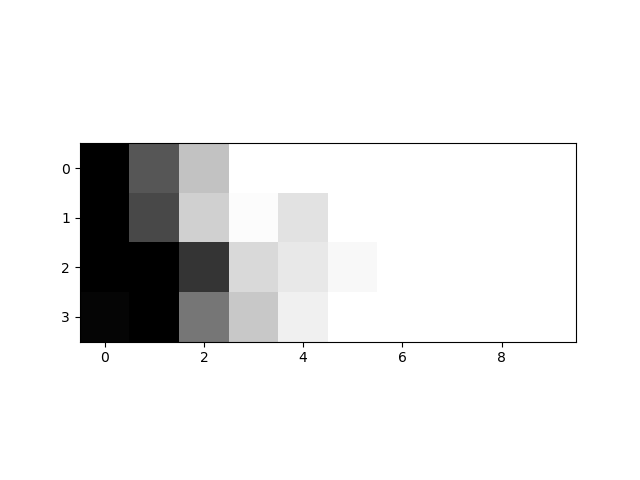

In [548]:
plt.figure()
plt.imshow(np.abs(dot_matrix[:threshold_21cm, :threshold_fg]), norm=colors.LogNorm(1e0, 1e2), cmap='Greys')

<IPython.core.display.Javascript object>


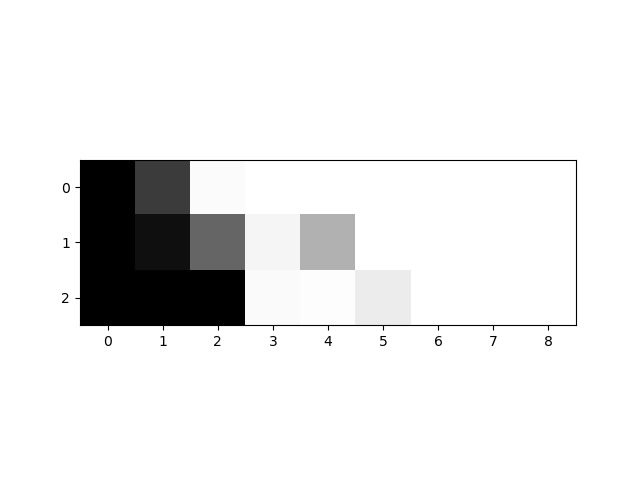

In [549]:
plt.figure()
plt.imshow(np.abs(dot_matrix_d[:threshold_21cmd, :threshold_fg_d]), norm=colors.LogNorm(1e0, 1e2), cmap='Greys')

In [560]:
np.sum(np.abs(dot_matrix[:threshold_21cm, :threshold_fg])) \
/ np.sum(np.abs(dot_matrix[:threshold_21cm, threshold_fg:]))

1.6580358456379591

In [561]:
np.sum(np.abs(dot_matrix_d[:threshold_21cmd, :threshold_fg_d])) \
/ np.sum(np.abs(dot_matrix_d[:threshold_21cmd, threshold_fg_d:]))

1.8206231618663054

<IPython.core.display.Javascript object>


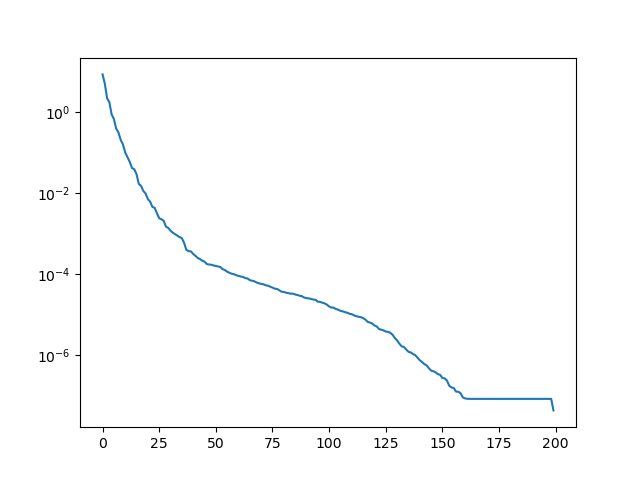

In [514]:
plt.figure()
plt.plot(np.sqrt(Sm))
plt.yscale('log')

In [504]:
threshold_fg_d

0

In [320]:
iS = np.identity(S.size)
#np.fill_diagonal(iS, np.where(S > 1e12, 1e12/S, 1))
#np.fill_diagonal(iS, 4e-7/S.clip(4e-7, np.Inf))
iS[:18,:18] = 0
#iS[:16,:16] = 0
Cinv = np.dot(V.T, np.dot(iS, U.T))

<IPython.core.display.Javascript object>


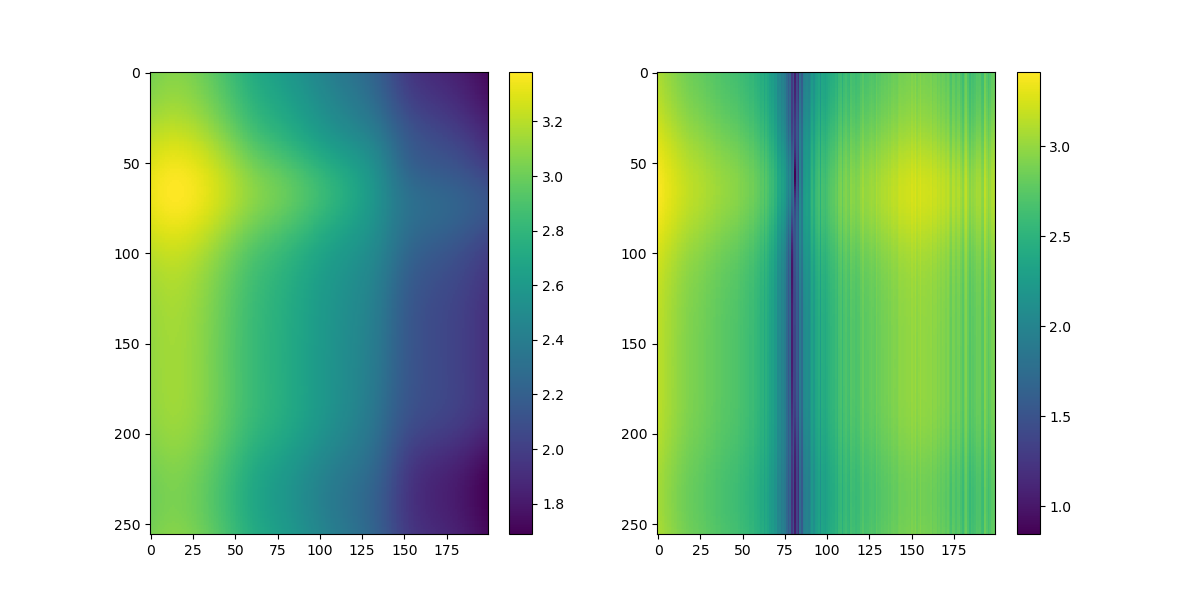

In [321]:
plt.figure(figsize=(12,6))
plt.subplot(121)
uvtools.plot.waterfall(idata, mode='log')
plt.colorbar()
plt.subplot(122)
uvtools.plot.waterfall(np.dot(Cinv, idata.T).T, mode='log')
plt.colorbar()

<IPython.core.display.Javascript object>


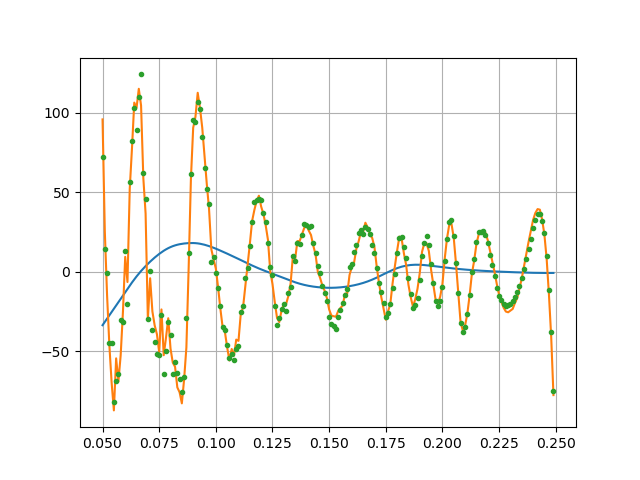

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [322]:
plt.figure()
plt.plot(freqs, np.mean(idata_flattened[-50:], axis=0))
plt.plot(freqs, 1e3*np.mean(np.dot(Cinv, idata_flattened[-50:].T).T, axis=0))
plt.plot(freqs, 1e3*np.dot(Cinv, reor), '.')
plt.grid()

In [323]:
detect = np.mean(np.dot(Cinv, idata_flattened.T).T, axis=0)
template = np.dot(Cinv, reor)
print(np.dot(detect, template) / np.dot(template, template))

(1.0023462106481245+0j)
